# Coin Detection

In [16]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [17]:
img = cv2.imread("CoinImages/IndianCoin1.jpeg")
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grey, (19, 19), 2.5)
# blurred = cv2.convertScaleAbs(blurred, alpha=0.5, beta=50)
# blurred = cv2.normalize(blurred, None, alpha=100, beta=150, norm_type=cv2.NORM_MINMAX)
# blurred = cv2.addWeighted(blurred, 1.5, cv2.GaussianBlur(blurred, (0, 0), 3), -0.5, 0)
# blurred = cv2.normalize(blurred, None, alpha=100, beta=150, norm_type=cv2.NORM_MINMAX)
# # blurred = cv2.addWeighted(blurred, 5.5, cv2.GaussianBlur(blurred, (0, 0), 3), -0.5, 0)
# blurred = cv2.GaussianBlur(grey, (35, 35), 10)
# kernel = np.array([[-1, -1, -1], 
#                    [-1,  9, -1], 
#                    [-1, -1, -1]])
# sharp = cv2.filter2D(blurred, -1, kernel)

In [18]:
kernel = np.array([[-1, -1, -1], 
                   [-1,  9, -1], 
                   [-1, -1, -1]])
sharp = cv2.filter2D(blurred, -1, kernel)

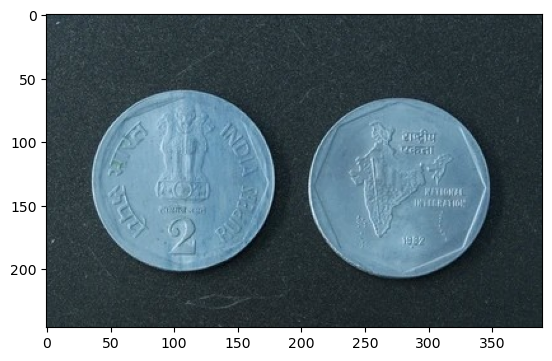

In [19]:
plt.imshow(img)
plt.show()

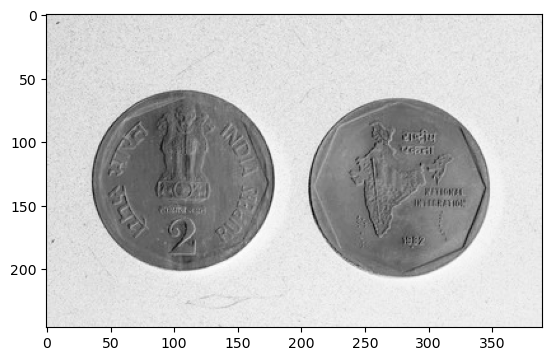

In [20]:
plt.imshow(grey, cmap="Greys")
plt.show()

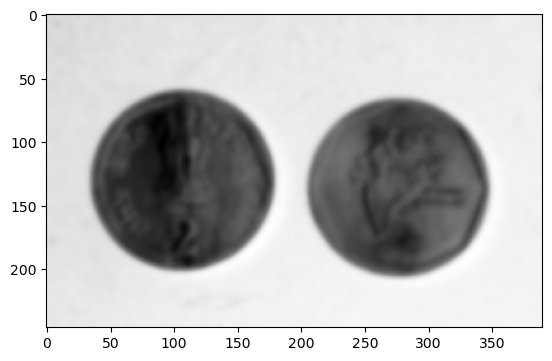

In [21]:
plt.imshow(blurred, cmap='Greys')
plt.show()

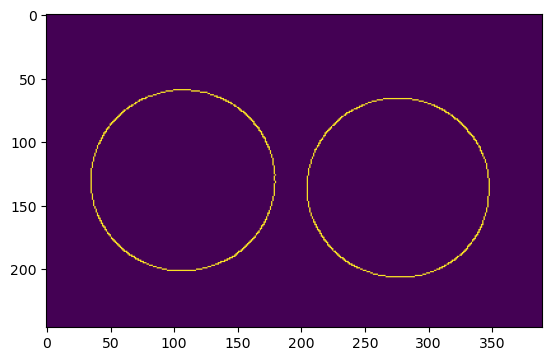

In [22]:
# Creating the edges using Canny Edge detection
outline = cv2.Canny(blurred, 80, 200)
plt.imshow(outline)
plt.show()

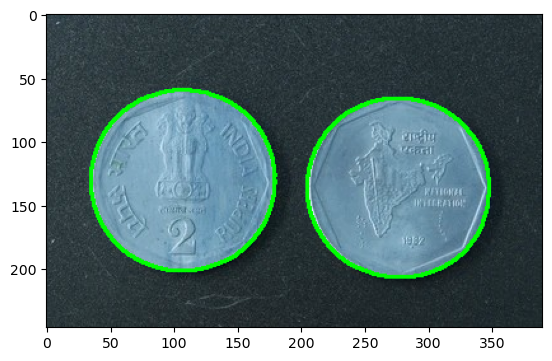

In [23]:
cnts, _ = cv2.findContours(outline,
                           cv2.RETR_EXTERNAL,
                           cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, cnts, -1, (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [24]:
print(f"Number of coins: {len(cnts)}")

Number of coins: 2


# Trying to brute force the result:

In [25]:
#best_count = 0
#best_params = (0, 0)
#best_outline = None
#best_contours = None

#for std in np.arange(0.5, 10, 0.001):
#    blurred = cv2.GaussianBlur(grey, (19, 19), std)
#    for low_thresh in range(0, 150, 10):
#        for high_thresh in range(100, 250, 10):
#            outline = cv2.Canny(sharp, low_thresh, high_thresh)
#            cnts, _ = cv2.findContours(outline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#            print(f"Low: {low_thresh}, High: {high_thresh}, std: {std}, count={cnts}")
            # Store the best configuration (closest to 8 coins)
#            if 6 <= len(cnts) <= 10:  # Acceptable range considering possible over/under detection
#                best_count = len(cnts)
#                best_params = (low_thresh, high_thresh)
#                best_outline = outline
#                best_contours = cnts

#img_contours = img.copy()
#if best_contours:
#    cv2.drawContours(img_contours, best_contours, -1, (0, 255, 0), 2)

#best_params, best_count

In [26]:
def detect_coins_canny(image_path):
    img = cv2.imread(image_path)
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(grey, (15, 15), 2)

    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Coins: {len(contours)}")
    plt.axis("off")
    plt.show()

    return contours, img

def detect_coins_laplacian(image_path):
    img = cv2.imread(image_path)
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(grey, (15, 15), 2)

    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))  # Convert to uint8
    contours, _ = cv2.findContours(laplacian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Coins (Laplacian): {len(contours)}")
    plt.axis("off")
    plt.show()

    return contours, img

def detect_coins_hough(image_path):
    img = cv2.imread(image_path)
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(grey, (15, 15), 2)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
                               param1=100, param2=40, minRadius=30, maxRadius=60)

    img_hough = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(img_hough, (i[0], i[1]), i[2], (0, 255, 0), 2)

    # Show detected circles
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_hough, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Coins (Hough Transform): {len(circles[0]) if circles is not None else 0}")
    plt.axis("off")
    plt.show()

    return len(circles[0]) if circles is not None else 0


def segment_coins(contours, img):
    segmented_coins = []
    num_coins = len(contours)
    rows = (num_coins // 5) + 1
    plt.figure(figsize=(10, rows*2))

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        coin = img[y:y+h, x:x+w]
        segmented_coins.append(coin)
        plt.subplot(rows, 5, i+1)
        plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    plt.show()
    return segmented_coins

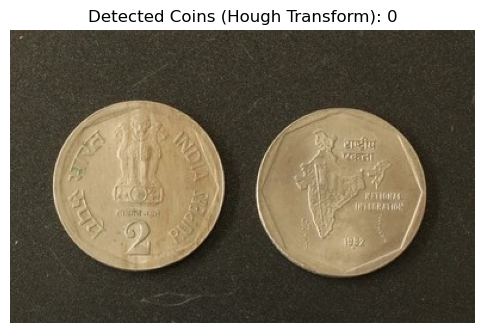

Total coins detected (Hough Transform): 0


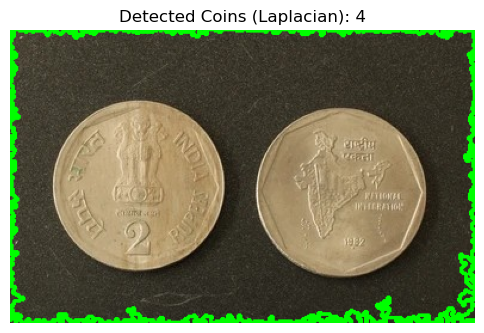

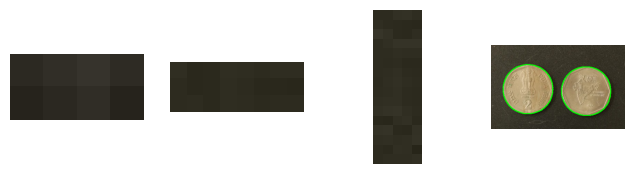

Total coins detected (Laplacian): 4


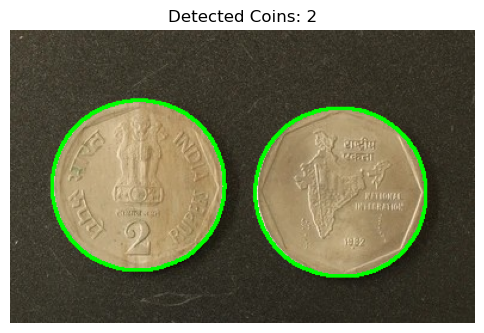

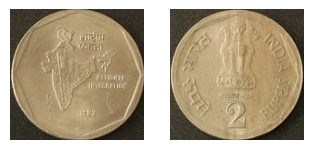

Total number of coins detected: 2


In [27]:
image = "CoinImages/IndianCoin1.jpeg"

num_coins_hough = detect_coins_hough(image)
print(f"Total coins detected (Hough Transform): {num_coins_hough}")

contours_laplacian, img_laplacian = detect_coins_laplacian(image)
segmented_coins = segment_coins(contours_laplacian, img)
print(f"Total coins detected (Laplacian): {len(contours_laplacian)}")

contours, img = detect_coins_canny(image)
segmented_coins = segment_coins(contours, img)
print(f"Total number of coins detected: {len(contours)}")

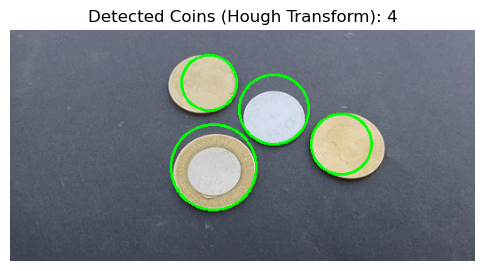

Total coins detected (Hough Transform): 4


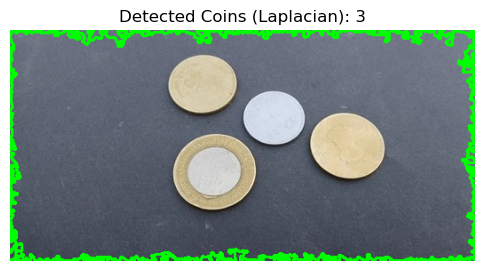

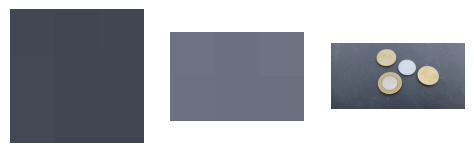

Total coins detected (Laplacian): 3


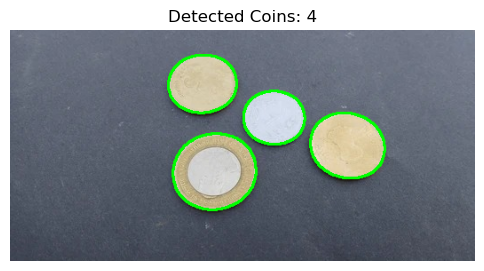

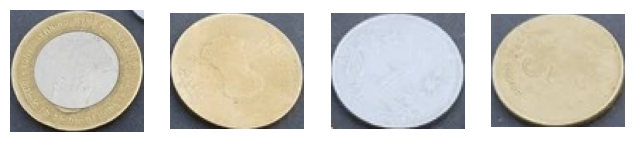

Total number of coins detected: 4


In [28]:
image = "CoinImages/IndianCoin2.jpeg"
img = cv2.imread(image)

num_coins_hough = detect_coins_hough(image)
print(f"Total coins detected (Hough Transform): {num_coins_hough}")

contours_laplacian, img_laplacian = detect_coins_laplacian(image)
segmented_coins = segment_coins(contours_laplacian, img)
print(f"Total coins detected (Laplacian): {len(contours_laplacian)}")

contours, img = detect_coins_canny(image)
segmented_coins = segment_coins(contours, img)
print(f"Total number of coins detected: {len(contours)}")

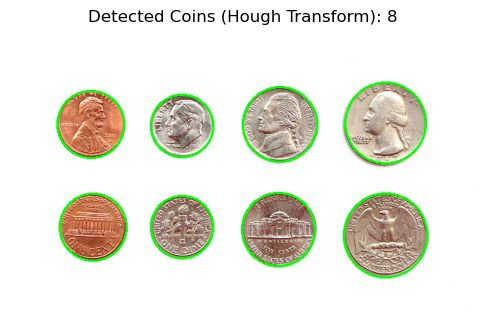

Total coins detected (Hough Transform): 8


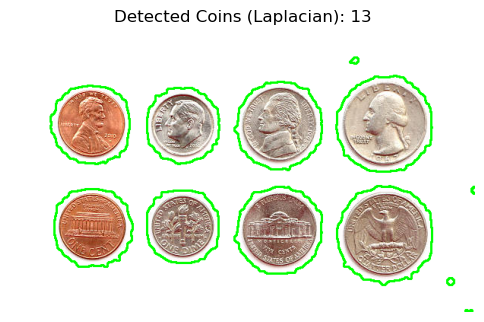

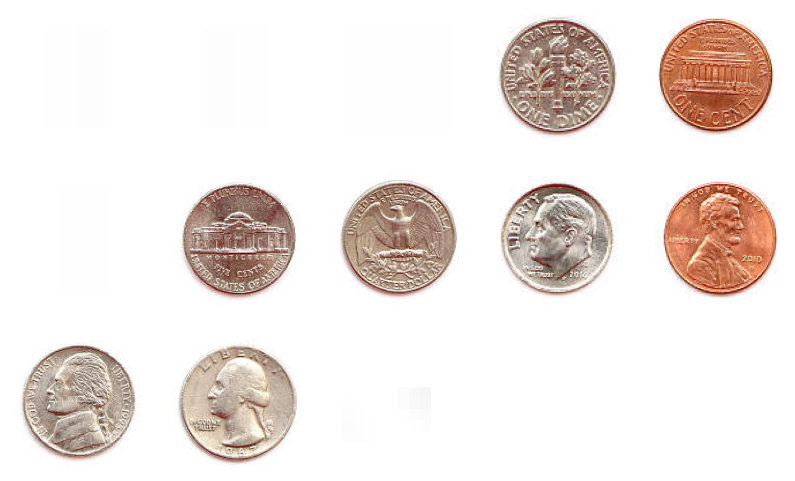

Total coins detected (Laplacian): 13


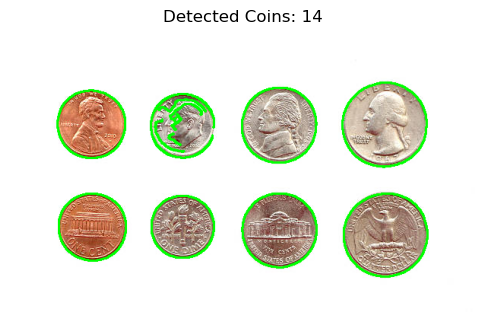

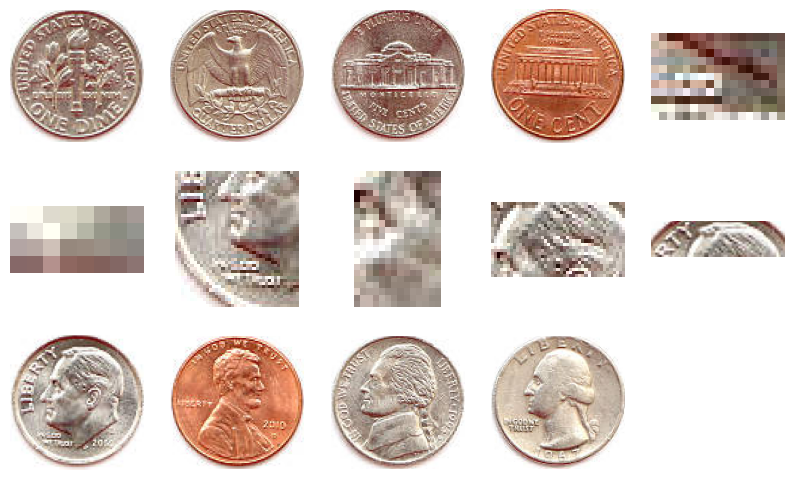

Total number of coins detected: 14


In [29]:
image = "CoinImages/AmericanCoins.jpg"
img = cv2.imread(image)

num_coins_hough = detect_coins_hough(image)
print(f"Total coins detected (Hough Transform): {num_coins_hough}")

contours_laplacian, img_laplacian = detect_coins_laplacian(image)
segmented_coins = segment_coins(contours_laplacian, img)
print(f"Total coins detected (Laplacian): {len(contours_laplacian)}")

contours, img = detect_coins_canny(image)
segmented_coins = segment_coins(contours, img)
print(f"Total number of coins detected: {len(contours)}")